# Time Series Data with the Howso Engine

## Overview

Time series analysis can provide users with a method of modeling temporal data to understand trends over time. The Engine can be used to forecast series data or make predictions at specific timesteps. When using the Howso Engine for time-series analysis, series are represented as a set of cases with a matching series ID. 

This recipe will demonstrate how to leverage Howso Engine's time series tools to make time series predictions.

In [1]:
from IPython.display import (
    display,
    Markdown,
)
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from howso import engine
from howso.engine import (
    Session,
    Trainee,
)
from howso.utilities import infer_feature_attributes

## Step 1: Load Data

The data we will be using is an example set of time series data for three stocks.

In [2]:
df = pd.read_csv('../../../data/example_timeseries.csv')
df

,ID,f1,f2,f3,date
0,31855,245.470,262.970,244.950,2010-01-31
1,31855,253.030,254.790,238.610,2010-02-28
2,31855,268.290,271.060,253.030,2010-03-31
3,31855,273.260,281.210,268.290,2010-04-30
4,31855,251.150,277.590,239.430,2010-05-31
...,...,...,...,...,...
4751,164306,3318.488,3318.488,3227.954,2019-04-30
4752,164306,3103.766,3323.469,3103.766,2019-05-31
4753,164306,3321.692,3332.855,3096.812,2019-06-30
4754,164306,3371.001,3418.161,3345.877,2019-07-31


Plot data for visual understanding

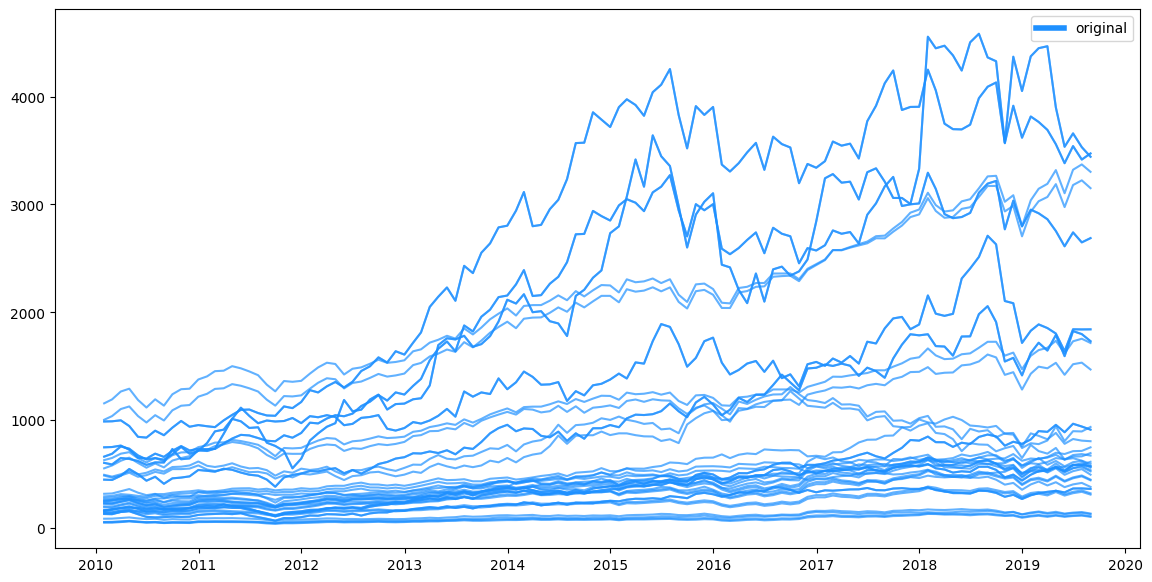

In [3]:
# Convert "date" column to `datetime` type.
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for series_id in df["ID"].unique():
    series_df = df.loc[df['ID'] == series_id].sort_values(by="date")
    ax.plot(series_df['date'], series_df['f1'], c="dodgerblue", alpha=0.7)

legend_elements = [
    Line2D([0], [0], color="dodgerblue", lw=4, label="original")
]

ax.legend(handles=legend_elements)

plt.show()

## Step 2: Define the Feature Attributes

The feature attributes must be defined whenever using the Howso Engine. When we use `infer_feature_attributes` for time-series data, it is crucial that both the `time_feature_name` and `id_feature_name` parameters are specified correctly.

Additionally, we print out the resulting feature attributes. It is important to verify feature attributes are correct.

In [4]:
# Identify id-feature and time-feature
id_feature_name = "ID"
time_feature_name = "date"
features = infer_feature_attributes(
    df,
    time_feature_name=time_feature_name,
    id_feature_name=id_feature_name
)

features

{'ID': {'type': 'nominal',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'id_feature': True,
  'bounds': {'allow_null': False}},
 'f1': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 4,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': np.float64(20.0855),
   'max': np.float64(8103.0839),
   'allow_null': True},
  'time_series': {'type': 'rate',
   'rate_max': [0.0012430732030380078],
   'rate_min': [-0.0007645089495998057]}},
 'f2': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 4,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': np.float64(20.0855),
   'max': np.float64(8103.0839),
   'allow_null': True},
  'time_series': {'type': 'rate',
   'rate_max': [0.001388600638608105],
   'rate_min': [-0.0006637496387383802]}},
 'f3': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 4,
  'original_type': {'data_type': 'nu

## Step 3: Train a Trainee and Analyze

The one change between regular analysis using non-time series data and time series data is that during the `train` call, Engine calculates time information (deltas and rates) for each feature and adds this information in as additional features in your dataset. 

**So, to utilize these new features which contain time information within the prediction, they have to be called as context features. 
The names of these features can be obtained after the `train` call using the `get_cases` call. Then, these can be passed in as context features to the `analyze` and `react` calls to make a time series prediction.**

In [5]:
# Create the Trainee
t = Trainee(
    features=features,
    overwrite_existing=True
)

session1 = Session('train_session_1', metadata={'data': 'training data'})

# Train
t.train(df)

# Store actual record data which includes all of the ts information
cases_df = t.get_cases(
    session=session1
)

# Print out ts information
cases_df

,.date_delta_1,.date_lag_1,.f1_lag_1,.f1_rate_1,.f2_lag_1,.f2_rate_1,.f3_lag_1,.f3_rate_1,.series_progress,.series_progress_delta,ID,date,f1,f2,f3
0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.008696,31855,2010-01-31,245.470,262.970,244.950
1,2419200.0,2010-01-31T00:00:00,245.470,0.000003,262.970,-0.000003,244.950,-0.000003,0.008002,0.008002,31855,2010-02-28,253.030,254.790,238.610
2,2678400.0,2010-02-28T00:00:00,253.030,0.000006,254.790,0.000006,238.610,0.000005,0.016862,0.008860,31855,2010-03-31,268.290,271.060,253.030
3,2592000.0,2010-03-31T00:00:00,268.290,0.000002,271.060,0.000004,253.030,0.000006,0.025436,0.008574,31855,2010-04-30,273.260,281.210,268.290
4,2678400.0,2010-04-30T00:00:00,273.260,-0.000008,281.210,-0.000001,268.290,-0.000011,0.034296,0.008860,31855,2010-05-31,251.150,277.590,239.430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751,2592000.0,2019-03-31T00:00:00,3191.164,0.000049,3215.505,0.000040,3092.292,0.000052,0.964847,0.008574,164306,2019-04-30,3318.488,3318.488,3227.954
4752,2678400.0,2019-04-30T00:00:00,3318.488,-0.000080,3318.488,0.000002,3227.954,-0.000046,0.973707,0.008860,164306,2019-05-31,3103.766,3323.469,3103.766
4753,2592000.0,2019-05-31T00:00:00,3103.766,0.000084,3323.469,0.000004,3103.766,-0.000003,0.982281,0.008574,164306,2019-06-30,3321.692,3332.855,3096.812
4754,2678400.0,2019-06-30T00:00:00,3321.692,0.000018,3332.855,0.000032,3096.812,0.000093,0.991140,0.008860,164306,2019-07-31,3371.001,3418.161,3345.877


Here, you can see the ts information that was added to the feature set when the data was trained into Engine. It is important that these time series features are added as context features for `analyze` and `react`.

## Step 4: Measure Trainee Accuracy

Below we do a typical `react_aggregate` to measure how well the Trainee can predict different feature values of the trained cases.

In [6]:
# Specify Context and Action Features
action_features = ['f1']
context_features = cases_df.columns.drop(action_features).to_list()

# Targeted Analysis
t.analyze(context_features=context_features, action_features=action_features)

# Calculate overall error metrics
results = t.react_aggregate(
    action_feature=action_features[0],
    details={"prediction_stats": True}
)

results['f1']

mae               13.539949
spearman_coeff     0.998877
rmse              31.572398
r2                 0.998904
recall                  NaN
precision               NaN
mcc                     NaN
accuracy                NaN
Name: f1, dtype: float64

## Step 5: Generate Series Data Generatively

The prediction stats above were obtained using discriminative predictions. Now, we will use a generative `react_series` to forecast numerous series. For this, we will set the `desired_conviction` to be one, which indicates average surprisal for the generated cases.

Here, we are utilizing generative reacts on the entire dataset to generate predictions for each series. This is done by providing the initial value which is the first actual case of each series and generating the rest. This is done using the `initial_features` and `initial_values` parameters of `react_series`.

Time series may also be generated without providing the initial values. 

In [7]:
initial_features = df.columns.tolist()
initial_values = []
context_values = cases_df[context_features]

for id in df.ID.unique():
    initial_values.append(df[df.ID == id].iloc[1].values.tolist())

In [8]:
action_features = df.columns.tolist()

initial_features = df.columns.tolist()
initial_values = []
for id in df.ID.unique():
    initial_values.append(df[df.ID == id].iloc[1].values.tolist())

# Perform generative react
series_output =  t.react_series(
    action_features=action_features,
    initial_features=initial_features,
    initial_values=initial_values,
    final_time_steps= ['2019-07-31T00:00:00'],
    desired_conviction=1,
    generate_new_cases='always',
    num_series_to_generate=len(initial_values),
    series_id_tracking = 'fixed',
)
result_gen = series_output['action']


And lastly, let's visualize our generated series data to compare it to the original trained data.

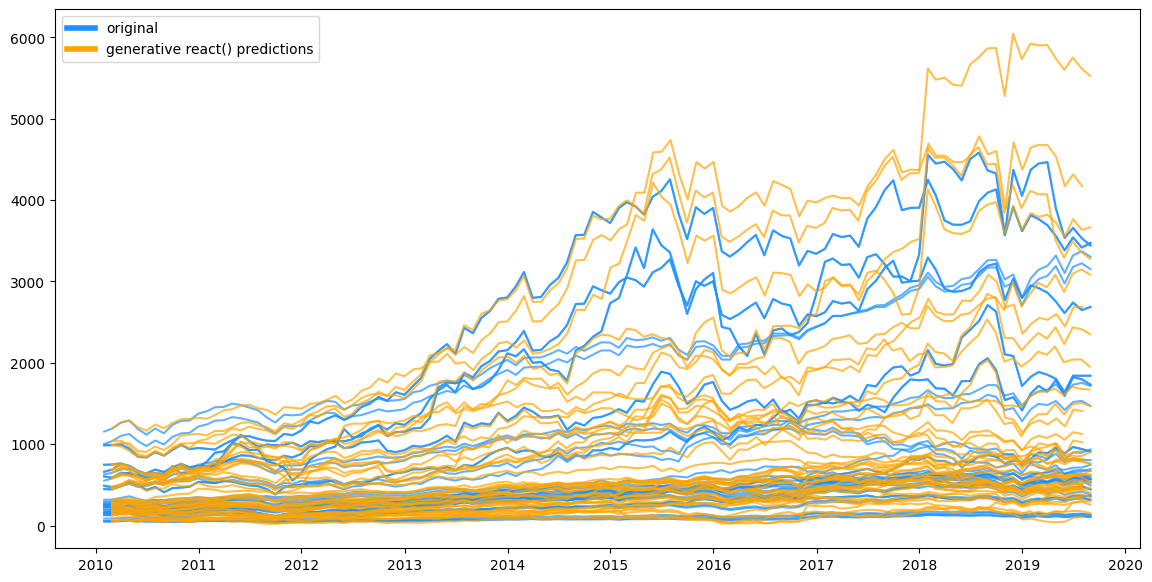

In [9]:
# Convert "date" column to `datetime` type.
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for series_id in df["ID"].unique():
    series_df = df.loc[df['ID'] == series_id].sort_values(by="date")
    ax.plot(series_df['date'], series_df['f1'], c="dodgerblue", alpha=0.7)

for series_id in result_gen["ID"].unique():
    result_df = result_gen.loc[result_gen['ID'] == series_id].sort_values(by="date")
    ax.plot(result_df['date'], result_df['f1'], c="orange", alpha=0.7)


legend_elements = [
    Line2D([0], [0], color="dodgerblue", lw=4, label="original"),
    Line2D([0], [0], color="orange", lw=4, label="generative react() predictions"),
]

ax.legend(handles=legend_elements)

plt.show()

# Note: The first case in each time series is not graphed as it is provided and thus not generated

# Summary

In this recipe we demonstrate how to do some general purpose time-series analysis using the Howso Engine. We discuss how to properly configure the feature attributes, measure Trainee accuracy, and how to generatively create new series data.